In [2]:
import pandas as pd
import numpy as np

from keras.models import load_model

from PIL import Image
from skimage import transform


In [3]:
model = load_model('Models3/MO.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
test_image = '../images/00000001_001.png'
test_image2 = '../images/00000032_016.png'

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (256, 256, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load(test_image2)
results = model.predict(image)

C:\Users\saber\Anaconda3\envs\tfGPU\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\saber\Anaconda3\envs\tfGPU\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [6]:
total = 0
for i in results:
    total =  i + total
    

In [7]:
results

[array([[0.04143209]], dtype=float32),
 array([[0.00737416]], dtype=float32),
 array([[0.01710149]], dtype=float32),
 array([[0.00895581]], dtype=float32),
 array([[0.04231977]], dtype=float32),
 array([[0.00584243]], dtype=float32),
 array([[0.0037385]], dtype=float32),
 array([[0.0001143]], dtype=float32),
 array([[0.2286138]], dtype=float32),
 array([[0.0215163]], dtype=float32),
 array([[0.02131721]], dtype=float32),
 array([[0.00823522]], dtype=float32),
 array([[0.0029615]], dtype=float32),
 array([[0.01556406]], dtype=float32)]

In [8]:
total

array([[0.42508662]], dtype=float32)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 254, 254, 32) 9248        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [10]:
from keras.preprocessing import image

img = image.load_img(test_image2, target_size=(256,256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 256, 256, 3)


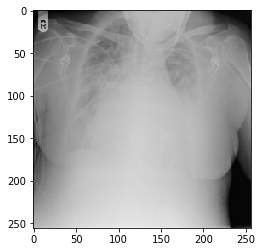

In [54]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [12]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[1:]]
activation_model = models.Model(inputs=model.input, outputs = layer_outputs)

In [13]:
activations = activation_model.predict(img_tensor)

In [14]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 256, 256, 32)


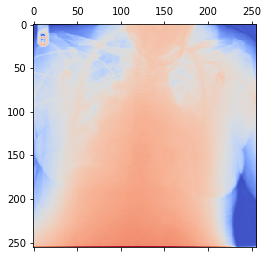

In [15]:
plt.matshow(first_layer_activation[0,:,:,8],cmap='coolwarm')

C:\Users\saber\Anaconda3\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


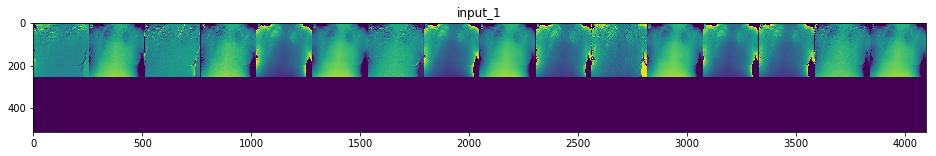

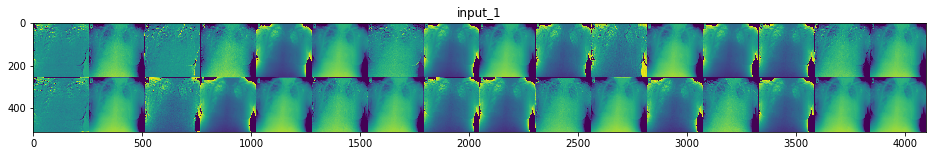

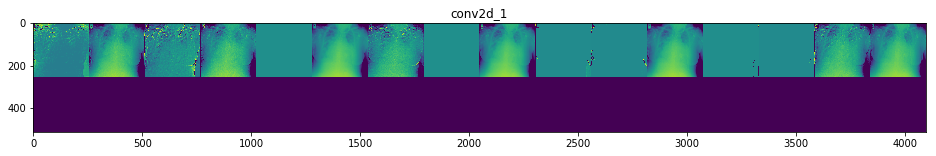

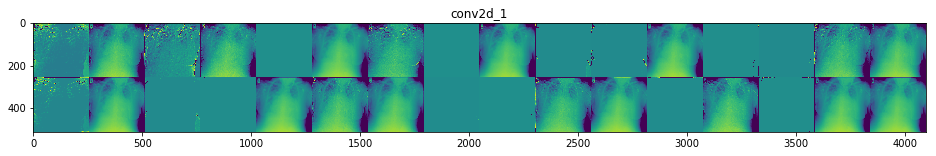

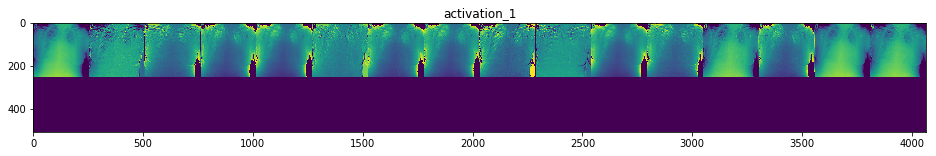

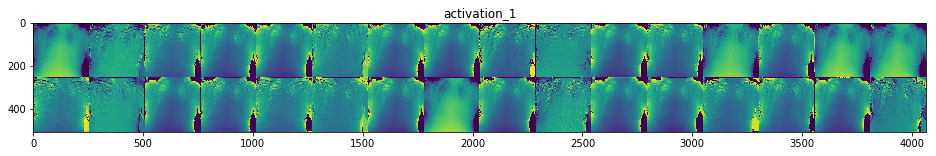

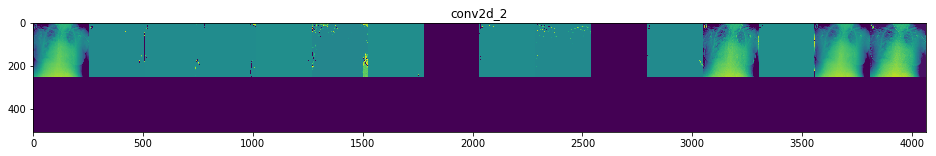

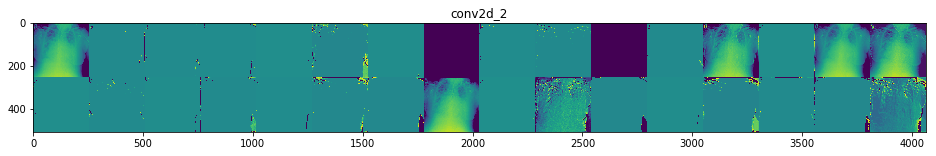

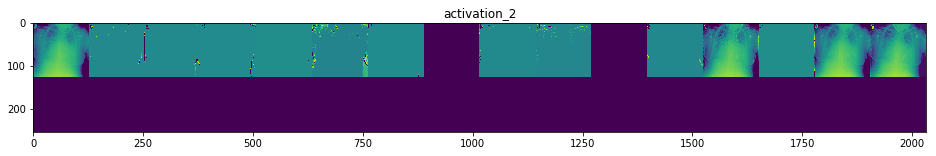

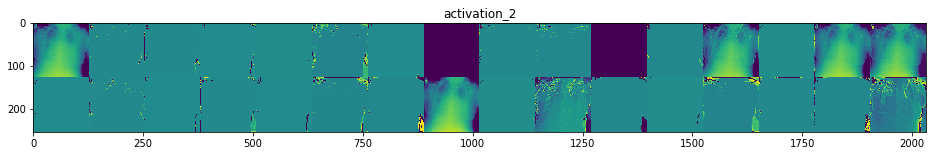

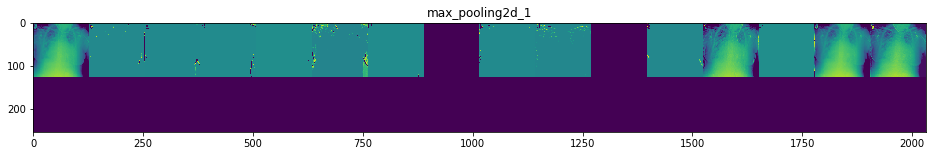

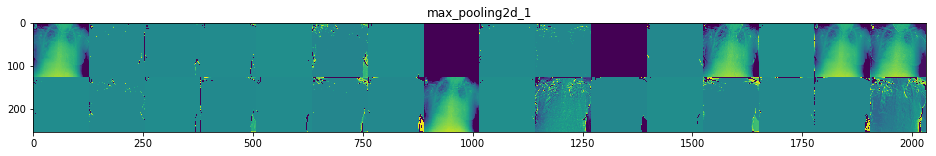

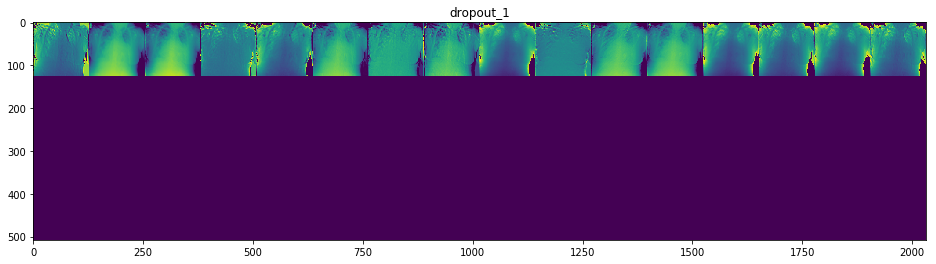

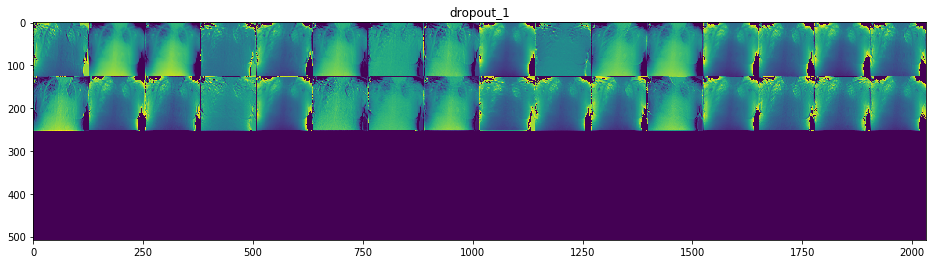

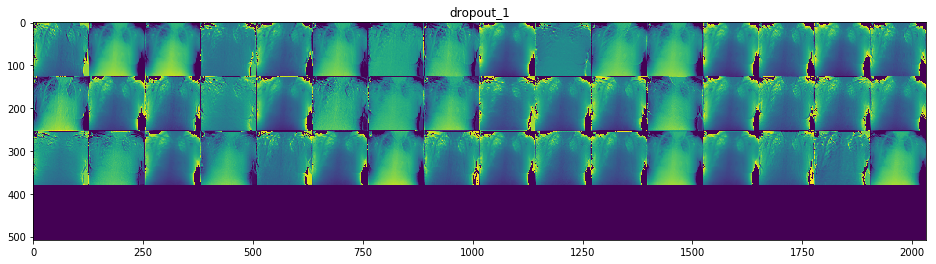

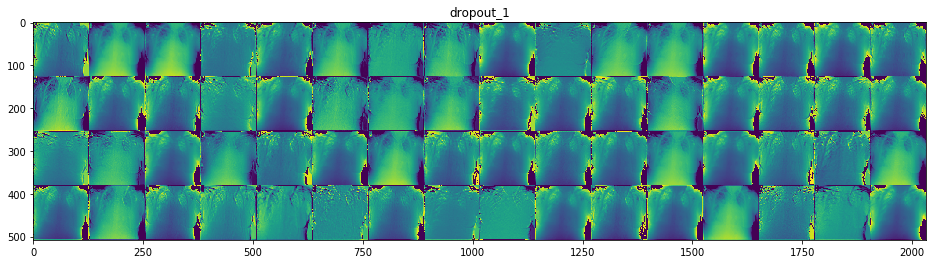

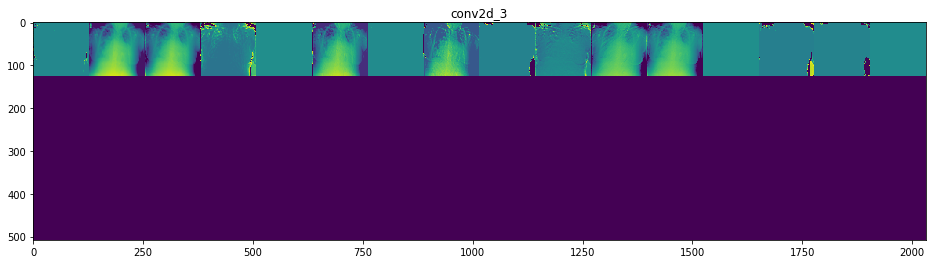

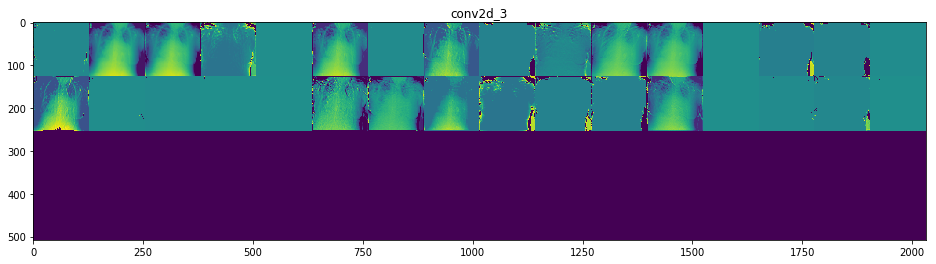

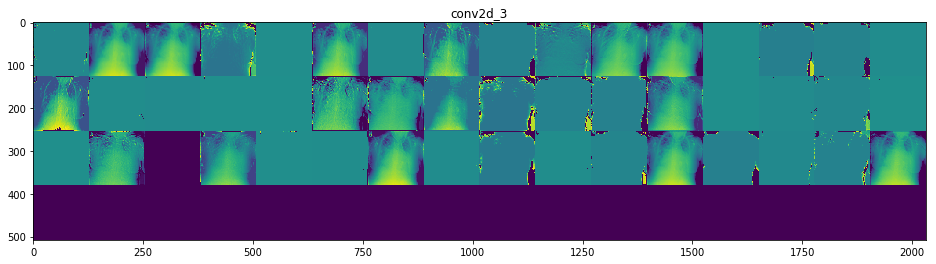

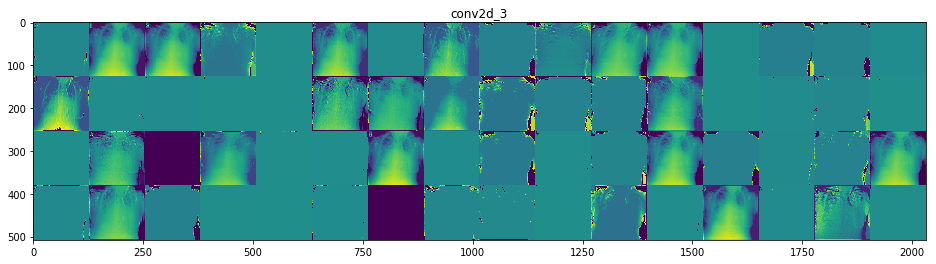

In [18]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0 , 256).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image
        scale = 1. / size

        plt.figure(figsize=(scale * display_grid.shape[1],
        scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [25]:
from keras import backend as K

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, 0])

In [26]:
grads = K.gradients(loss, model.input)[0]

In [27]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [28]:
iterate = K.function([model.input], [loss, grads])

In [29]:
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [31]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [33]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [35]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        img = input_img_data[0]
        
    return deprocess_image(img)


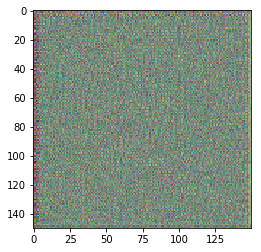

In [47]:
plt.imshow(generate_pattern('conv2d_3',0))

In [52]:
layer_output
last_conv_layer = model.get_layer('block5_conv3')

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


In [ ]:
image_ouput = model.output[:, 256]

In [53]:
grads = K.gradients(layer_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

AttributeError: 'str' object has no attribute 'output'